# Calculations on TiO2 and a monolayer of MoS2

Calculation of TiO2 and a Monolayer of MoS2 with the Fleur code. We converge the systems and calculate a Bandstructure and DOS.

Author: Jens Broeder 2017

In [62]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from aiida import load_dbenv, is_dbenv_loaded
if not is_dbenv_loaded():
    load_dbenv()
from aiida.orm import Code, load_node
from aiida.orm import DataFactory as DF
from aiida.work.run import run, async, submit
from aiida_fleur.workflows.scf import fleur_scf_wc
from aiida_fleur.workflows.band import fleur_band_wc
from aiida_fleur.workflows.dos import fleur_dos_wc
from aiida_fleur.workflows.eos import fleur_eos_wc
#from plot_methods.plot_methods import single_scatterplot, multiple_scatterplots
#from plot_methods.plot_fleur_aiida import plot_fleur, plot_fleur_mn
StructureData, ParameterData, KpointsData, FleurinpData = DF('structure'), DF('parameter'), DF('array.kpoints'), DF('fleur.fleurinp')

In [64]:
###############################
codename = 'fleur_inpgen@localhost'
codename2 = 'fleur-0.27@localhost'
###############################
inpgen = Code.get_from_string(codename)
fleur = Code.get_from_string(codename2)

# Perparing the crystal structures and ParameterData nodes:

In [4]:
bohr_a_0 = 0.52917721092 # A
ba = bohr_a_0

Create the structures or better load the nodes from the db

## TiO2

In [116]:
# From Cif file
cell =[[4.2262, 0.0, 0.0],
 [2.58780115127827e-16, 4.2262, 0.0],
 [1.6538793790145e-16, 1.6538793790145e-16, 2.70099]]
ti_o_structure = StructureData(cell=cell)
ti_o_structure.append_atom(position=(0.00, 0.00, 0.00), symbols='Ti')
ti_o_structure.append_atom(position=(2.1131, 2.1131, 1.350495), symbols='Ti')
ti_o_structure.append_atom(position=(1.261055818, 1.261055818, 0.0), symbols='O')
ti_o_structure.append_atom(position=(0.852044182, 3.374155818, 1.350495), symbols='O')
ti_o_structure.append_atom(position=(2.965144182, 2.965144182, 0.0), symbols='O')
ti_o_structure.append_atom(position=(3.374155818, 0.852044182, 1.350495), symbols='O')

#ti_o_structure2.store()
#ti_o_structure2 = load_node(76513)
print ti_o_structure2

uuid: c0916b9f-7a3f-4381-9de8-bc5328304a68 (pk: 76513)


We could just use the defaults, but we can also control what parameters Fleur should use 

In [9]:
ti_o_fleur_parameter = ParameterData(dict={
     u'comp': {u'kmax': 4.2, u'gmaxxc': 11.5, u'gmax': 13.9}, 
     u'atom': {u'lmax': 8, u'lnonsph': 6, u'jri': 551, u'rmt': 2.2, u'dx': 0.021, 
               u'element': u'Ti', u'lo': u'2p'}, 
     u'atom2': {u'element': u'O', u'jri': 311, u'dx': 0.033, u'lmax': 6, u'lnonsph': 4, 
                u'rmt': 1.2},
     u'soc' : {'theta' : 0.0, 'phi' : 0.0},
     u'kpt': {u'tkb': 0.001, u'div1' : 4 , u'div2' :  4 , u'div3' : 2}, 
     u'title': u'TiO2, rutile bulk'})
#ti_o_fleur_parameter.store()
#ti_o_fleur_parameter = load_node(76586)
print ti_o_fleur_parameter

uuid: a9723eda-898d-40e0-98e1-a864e5990867 (pk: 76586)


In [24]:
# U on Ti &ldaU l=2, u=5.5, j=0.5, l_amf=F /

## MoS2

In [53]:
a = 2.976320*ba
b = 5.155137*ba
c = 14.050000*ba
cell = [[a, a, 0.00],
        [-b, b, 0.00],
        [0.00, 0.00, c]]
mos2_structure = StructureData(cell=cell)
mos2_structure.append_atom(position=(0.00, 3.436758*ba, 2.998605*ba), symbols='S')
mos2_structure.append_atom(position=(0.00, 3.436758*ba, -2.998605*ba), symbols='S')
mos2_structure.append_atom(position=(0.00, -3.436758*ba, 0.00), symbols='Mo')
mos2_structure.pbc = (True, True, False)
#mos2_structure.store()
mos2_structure = load_node(76494)
print mos2_structure


uuid: db6ff8a3-769e-4094-94ae-1540930f67e8 (pk: 76494)


In [47]:
mos2_fleur_parameter = ParameterData(dict={
     u'comp': {u'kmax': 3.8, u'gmaxxc': 10.5, u'gmax': 12.6, u'jspins' : 2.0}, # dvac : 14.05000000 # bohr
     u'atom': {u'lmax': 10, u'lnonsph': 8, u'jri': 803, u'dx': 0.015, u'rmt': 2.43, 
               u'element': u'Mo'}, 
     u'atom2': {u'element': u'S', u'jri': 629, u'lmax': 8, u'lnonsph': 6, 
                u'rmt': 1.9, u'dx': 0.018}, 
     u'soc' : {'theta' : 0.0, 'phi' : 0.0},
     u'kpt': {u'tkb': 0.001, u'div1' : 4 , u'div2' :  4 , u'div3' : 1}, 
     u'title': u'MoS2, 2L monolayer'})
#mos2_fleur_parameter.store()
mos2_fleur_parameter = load_node(76457)
print mos2_fleur_parameter

uuid: a15d00cd-8e90-45bd-a60a-58f151d74245 (pk: 76457)


# Running the scf workflow, converging the charge density

We now define the workflow parameters, where we specify the resources queue names and so on we run in serial

In [12]:
scf_wc_para = ParameterData(dict={'fleur_runmax': 4, 
                                  'resources' : {"num_machines": 1},#{"tot_num_mpiprocs": 24},
                                  'walltime_sec':  300*60,
                                  'queue_name' : 'batch',#th123_node', 
                                  'serial' : True,
                                  'custom_scheduler_commands' : ''})#'#BSUB -P jara0043 \n#BSUB -M 120000  \n#BSUB -a intelmpi'})
#scf_wc_para.store()
#scf_wc_para = load_node(76532)
print scf_wc_para

uuid: 0d12c317-5001-492c-bbec-ccce5425fb8d (pk: 76532)


Execute below once and the workflow will be submited to the AiiDa Daemon, then lock the field. First we run with the given Parameters, then we will use the defaults.

In [13]:
label = 'fleur_scf_wc on TiO2'
description = 'Fleur scf of TiO2'
res_eos_ti_O = submit(fleur_scf_wc, wf_parameters=scf_wc_para, fleur=fleur, inpgen=inpgen, 
                      structure=ti_o_structure, calc_parameters=ti_o_fleur_parameter, 
                      _label=label, _description=description)

In [103]:
label = 'fleur_scf_wc on MoS2'
description = 'Fleur scf of MoS2'
res_eos_mo_s2 = submit(fleur_scf_wc, wf_parameters=scf_wc_para, fleur=fleur, inpgen=inpgen, 
                      structure=mos2_structure, calc_parameters=mos2_fleur_parameter, 
                      _label=label, _description=description)

In [104]:
label = 'fleur_scf_wc on TiO2 defaults'
description = 'Fleur scf of TiO2 defaults'
res_eos_ti_O = submit(fleur_scf_wc, wf_parameters=scf_wc_para, 
                      fleur=fleur, inpgen=inpgen, structure=ti_o_structure,
                      _label=label, _description=description)

In [105]:
label = 'fleur_scf_wc on MoS2 defaults'
description = 'Fleur scf of MoS2 defaults'
res_eos_ti_O = submit(fleur_scf_wc, wf_parameters=scf_wc_para, 
                      fleur=fleur, inpgen=inpgen, structure=mos2_structure, 
                      _label=label, _description=description)

In [4]:
ti_o_wc_uuids = []

If you have access to the plot_methods repo, you can use plot Fleur For visualisation of workflow results.

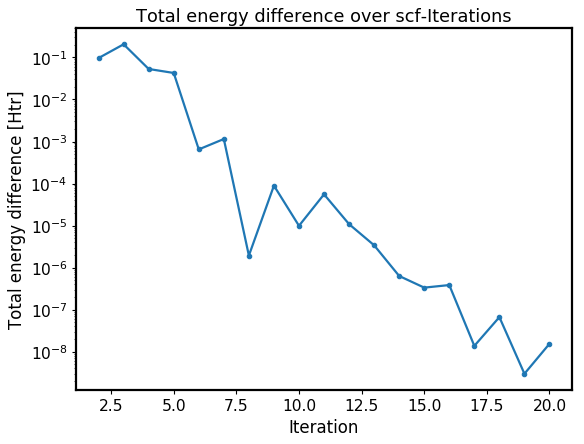

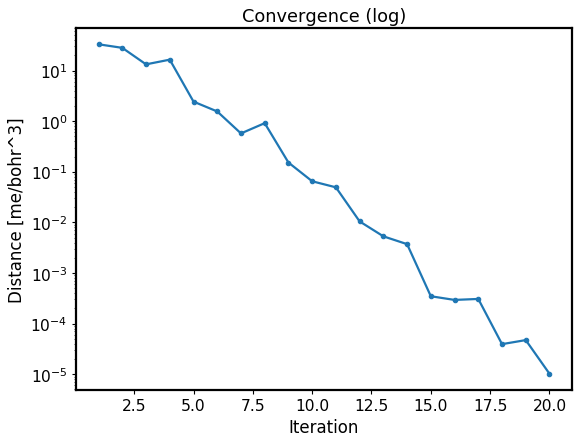

In [5]:
plot_fleur(ti_o_wc_uuids)

# Running the eos workflow, converging the charge density

Now we also calculate the equation of states with fleur for TiO2

In [30]:
eos_wc_para = ParameterData(dict={'fleur_runmax': 4, 
                                  'points' : 9, 
                                  'step' : 0.01, 
                                  'guess' : 1.00,
                                  'resources' : {"num_machines" : 1},#{"tot_num_mpiprocs": 24},
                                  'walltime_sec':  300*60,
                                  'queue_name' : 'batch',#th123_node', 
                                  'serial' : True,
                                  'custom_scheduler_commands' : ''})
#wf_para.store()
#wf_para = load_node(76873)
print wf_para

uuid: 00da378b-8a3e-46d5-8a6a-d07ea8b80e2d (pk: 76873)


In [31]:
label = 'fleur_eos_wc on TiO2'
description = 'Fleur eos of TiO2'
res_eos_ti_O = submit(fleur_eos_wc, wf_parameters=eos_wc_para, fleur=fleur, inpgen=inpgen, 
                      structure=ti_o_structure, calc_parameters=ti_o_fleur_parameter, 
                      _label=label, _description=description) 

In [38]:
ti_eos_wc_uuids = []

<IPython.core.display.Javascript object>


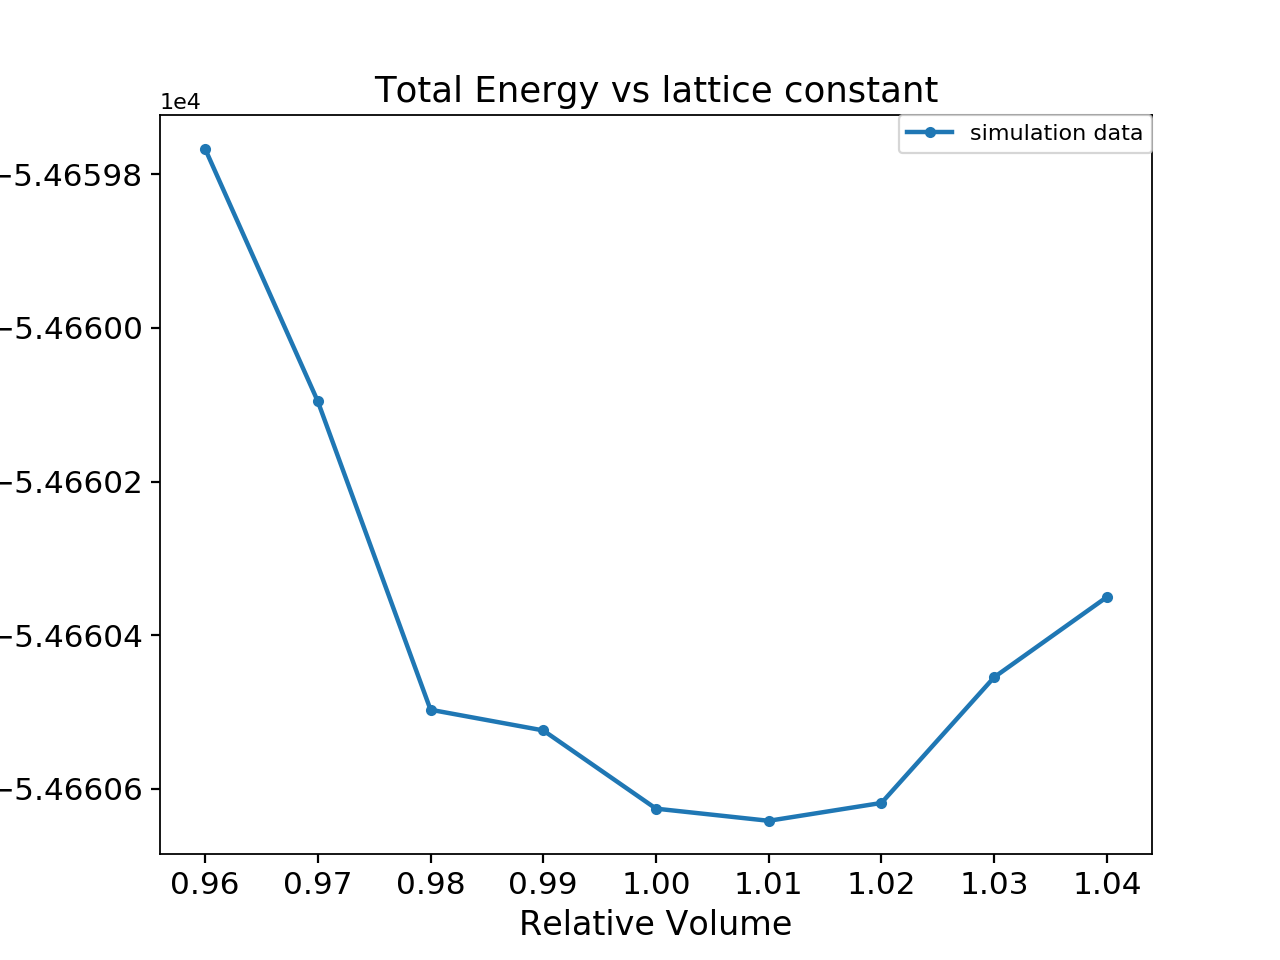

In [73]:
plot_fleur(ti_eos_wc_uuids)

# Running the dos workflow, from a converged calculation

We want to calculate a DOS and a Bandstructure ontop of the converged TiO2 calculation. 
From this we need to get the fleurinpData and remotefolder node of the last Fleur calculation from the scf workchain. We do so by hand here.

In [23]:
fleurinp = load_node()
fleur_calc = load_node() # from previous calculation look at scf nodes
remote = fleur_calc.out.remote_folder
    
wf_para = ParameterData(dict={'fleur_runmax' : 4,
                              'tria' : True,
                              'nkpts' : 800, 
                              'sigma' : 0.005,
                              'emin' : -0.30, 
                              'emax' :  0.80,
                              'queue_name' : 'batch',
                              'resources' : {"num_machines": 1},
                              'serial' : True,
                              'walltime_sec':  60*60})
#wf_para.store()
#wf_para = load_node(76866)
print wf_para

uuid: dadd568e-ac94-4ebc-ba47-b5a5918104fd (pk: 76866)


In [24]:
label = 'fleur_dos_wc on TiO2'
description = 'Fleur dos of TiO2'

In [25]:
res = submit(fleur_dos_wc, wf_parameters=wf_para, fleurinp=fleurinp, remote=remote, fleur=fleur, _label=label, _description=description)

In [34]:
dos_wc_uuids = []

/Users/broeder/aiida/aiida_run/repository-broeder_work/repository/node/12/d6/2815-b2dd-482a-8ad1-417d2a878bde/path/DOS.1


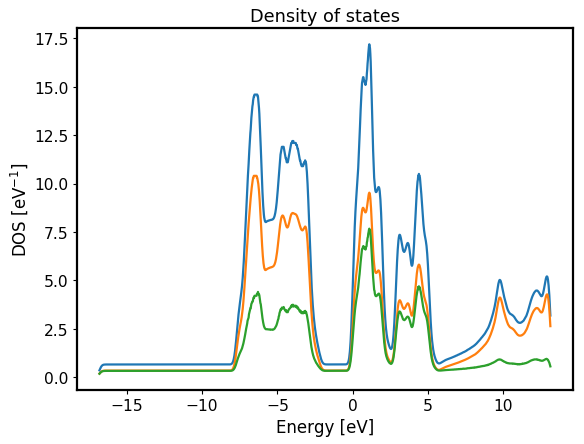

In [6]:
#plot_fleur(77013)

# Running the bands workflow, from a converged calculation

In [27]:
#fleurinp = load_node()
#fleur_calc = load_node() # from previous calculation
#remote = fleur_calc.out.remote_folder

wf_para = ParameterData(dict={'fleur_runmax' : 4,
                              'kpath' : 'auto',
                              'nkpts' : 800, 
                              'sigma' : 0.005,
                              'emin' : -0.30, 
                              'emax' :  0.80,
                              'queue_name' : 'batch',
                              'resources' : {"num_machines": 1},
                              'serial' : True,
                              'walltime_sec':  60*60})
#wf_para.store()
#wf_para = load_node()
print wf_para

uuid: 00da378b-8a3e-46d5-8a6a-d07ea8b80e2d (pk: 76873)


In [28]:
label = 'fleur_band_wc on TiO2'
description = 'Fleur band of TiO2'
res = submit(fleur_band_wc, wf_parameters=wf_para, fleurinp=fleurinp, remote=remote, fleur=fleur, _label=label, _description=description)

In [7]:
band_wc_uuids = []

/Users/broeder/aiida/aiida_run/repository-broeder_work/repository/node/d5/fc/602e-12ee-4ab5-b968-2616ca1af8ec/path/bands.1


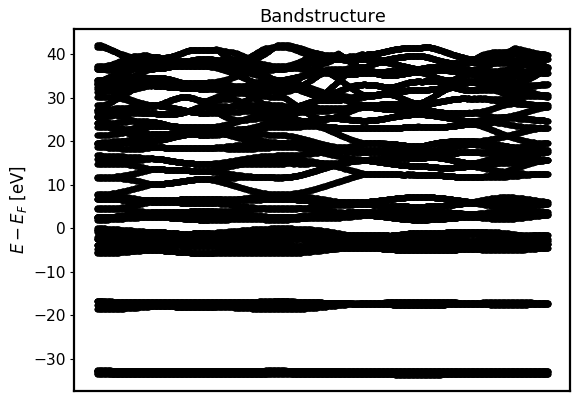

In [12]:
#plot_fleur(band_wc_uuids)

# Visualizing results: